# Brain Tumor Detection using Convolutional Neural Networks

*by Nat Koonmee, Tony Phan, and Nicholas Piccaro*

# Introduction

As machine learning is becoming more integrated into the lives of individuals and industries as a whole, it is beginning to encroach on the medical industry. The integration of machine learning in the medical field has an exciting and promising future, but also poses great risks in terms of its life and death nature. In the medical journal Cognitive and System Factors Contributing to Diagnostic Errors in Radiology, research has found that “the retrospective error rate among radiologic examinations is approximately 30%, with real-time errors in daily radiology practice averaging 3-5%. Nearly 75% of all medical malpractice claims against radiologists are related to diagnostic errors” (Lee). In an attempt to understand this gap and potentially provide assistance on this topic, we applied a Convolutional Neural Network to some brain tumor image classification sets.

In our project, we used two datasets:

1) ***[Br35H::Brain Tumor Detection 2020](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=pred):***

    A balanced dataset with 3000 images (1500 MRI images containing a tumor and 1500 MRI images with no tumor)

2) ***[Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection):***

    A lightweight dataset with 253 images (155 images that contained a brain tumor and 98 that did not).

With these two datasets, we created two separate CNN models to predict whether MRI contained brain tumors or not. The balanced dataset with 3000 images was able to achieve a high accuracy of ~95-99% accuracy while the lightweight model was only able to achieve about ~80% accuracy. 

Additionally, we explored which images were confusing the models the most by using confusion matrices and plotting the misclassified images to see if there were distinct characteristics among these. What we observed was the models tended to train for more circular discrepancies within the images to determine if an MRI had a tumor. Most tumors do follow this pattern but there are tumors that weren’t circular, causing our model to miss these cases.

With our models, we also wanted to ensure that they could be applied on real-time/newer MRI scans by not overfitting these datasets. We simulated this by cross predicting the models (the first model predicts the MRI scans on the alternative dataset and vice versa) and found that the accuracies remain consistent to the testing data. 


# Methods

## Work Contributions

**Nat Koonmee:** 
 * Created the Tensorflow CNN training model for both datasets. This included early stopping functionality to prevent overfitting.
 * Parameter tuned to achieve the highest accuracies on the models while trying to prioritize reducing false-negatives (Not identifying a tumor when there is one).
 * Fit the models with training data and graphed results (accuracy and loss).
 * Created Confusion Matrices and displayed the prediction accuracies of models.


**Tony Phan:**
 * Preprocessing the dataset (loading, reshaping images, and storing them in an array).
 * Splitting the data into training, testing, and validation sets.
 * Normalized the lightweight dataset to be balanced (155 tumor images and 155 non-tumor images).
 * Created Confusion Matrices and displayed the prediction accuracies of models.
 * Used the trained models to predict training, testing, and validation sets. Displayed the accuracies along with the models.
 * Created and graphed the set of images that were misclassified.
 * Analyzed the results of the misclassified images and performed cross evaluations to ensure not overfitting the data.


**Nicholas Piccaro:**
 * Preprocessing the dataset (loading, reshaping images, and storing them in an array).
 * Implemented cropping and standardizing using contours functionality.
 * Splitting the data into training, testing, and validation sets
 * Creating the image graphing functionality--including visualizing the images after preprocessing.
 * Analyzed the results of the misclassified images and performed cross evaluations to ensure not overfitting the data.
 * Implemented in-class CNN model 


## Setting up Environment

The following are necessary packages for running this notebook. 

In [1]:
import os
import pathlib
import cv2
import imutils

### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#all library needed for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19, DenseNet201, DenseNet121

from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot import confusion_matrix as cm
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Processing

### The datasets that are used can be found here:

***[Br35H::Brain Tumor Detection 2020](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=pred):***

***[Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection):***


Both of these datasets contain similar MRI scans--meaning they both can share the same preprocessing steps.

These images are contained in different file formats (some are .png and some are .jpg) and differ in sizes. To deal with this, we load in all the images below and resize them all to 100x100

### Cropping Data to be Standardized using Contours
We will be using the contouring concept covered in this article: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/.

In short, this concept normalizes all the brain/head shapes to the same width and height so our CNN model doesn't use head shape as a factor when predicting if an image contains a tumor.

Note: We don't actually use this concept in the final model. We found that using this concept created some resolution/distortion problems--which ultimately resulted in more false-negative classification and overall a lower accuracy.

In [3]:
def crop_brain_contour(image):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    

    return new_image

In [4]:
# Gets image paths. data_path = path to directory containing images
def getImagePaths(data_path):
    paths = []
    for r, _, f in os.walk(f'{data_path}'):
        for file in f:
            if not file.startswith('.'):
                paths.append(os.path.join(r, file))
    return paths

# Reads, crops, and resizes images and returns X and y values.
def populateXandY(paths, img_size=(100, 100)):
    X = []
    y = []
    for i, imagePaths in enumerate(paths):
        for image in imagePaths:
            img = cv2.imread(image)
#             img = crop_brain_contour(img)
            img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
            X.append(img)
            y.append(i)
    return np.array(X), np.array(y).reshape((-1, 1))

def get_X_and_y(data_path):
    # Load folders Yes and No separately.
    yes_paths = getImagePaths(f'{data_path}yes')
    no_paths = getImagePaths(f'{data_path}no')
    
    # Note: Ordering matters since we let enumerate create classes above.
    # Returns X, y
    return populateXandY([no_paths, yes_paths], img_size=(100, 100))

In [5]:
# Assuming these path exists in CWD
data_path = "./Br35H/"

# Note: Ordering matters since we let enumerate create classes above.
X, y = get_X_and_y(data_path)
print(f'Number of Yes: {y[y==1].shape[0]}\nNumber of No: {y[y==0].shape[0]}')

X.shape, y.shape

Number of Yes: 1500
Number of No: 1500


((3000, 100, 100, 3), (3000, 1))

This dataset contains an equal number of tumor images as non-tumor images so splitting can be performed normally.


### Splitting the data

Below we split the data using the splitting algorithm from A3 in CS445. This method uses a random seed if given and shuffles the dataset into 5 folds. This splitting method does not balanced the number of classes within each fold. 

The data will be split into 60% training, 20% testing, and 20% validation sets.



In [6]:
# Splits the data into train, test, and validation sets.
def train_test_validation(X, y, randSeed=None):
    # If random seed is given, set seed.
    if randSeed:
        np.random.seed(randSeed)
    
    # Randomly order X and T
    randorder = np.arange(X.shape[0])
    np.random.shuffle(randorder)
    X = X[randorder, :]
    y = y[randorder, :]
    
    n_folds = 5
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds 
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], y[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], y[start: ,]) )
    
    X_validate, T_validate = folds[0]
    X_test, T_test = folds[1]
    X_train, T_train = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    return X_train, T_train, X_test, T_test, X_validate, T_validate

# Calls train_test_validation and converts targets to categorical
def get_train_test_validation(X, y, randSeed=None):
    X_train, T_train, X_test, T_test, X_validate, T_validate = train_test_validation(X, y, randSeed=randSeed)
    T_train = to_categorical(T_train)
    T_test = to_categorical(T_test)
    T_validate = to_categorical(T_validate)
    
    return X_train, T_train, X_test, T_test, X_validate, T_validate

In [7]:
# Note: Running with random seed 42. Leave randSeed empty or randSeed=None if no seed.
X_train, T_train, X_test, T_test, X_validate, T_validate = get_train_test_validation(X, y, randSeed=42)

X_train.shape, T_train.shape, X_test.shape, T_test.shape, X_validate.shape, T_validate.shape

((1800, 100, 100, 3),
 (1800, 2),
 (600, 100, 100, 3),
 (600, 2),
 (600, 100, 100, 3),
 (600, 2))

## Lets Visualize Our Data

Below we will preview the first 50 elements in the training set.

In [8]:
# Plots n elements (10 per row) and whether the image is a tumor or not.
def plot_sample_images(X, y, n=50):
    columns_n = 10
    rows_n = int(np.ceil(n / columns_n))
    
    plt.figure(figsize=(20, 16))
    
    for i in range(n):
        plt.subplot(rows_n, columns_n, i + 1)
        plt.imshow(X[i])
        plt.title("Yes" if y[i][1] == 1 else "No", fontsize='x-large')
        plt.axis('off')
    plt.show()

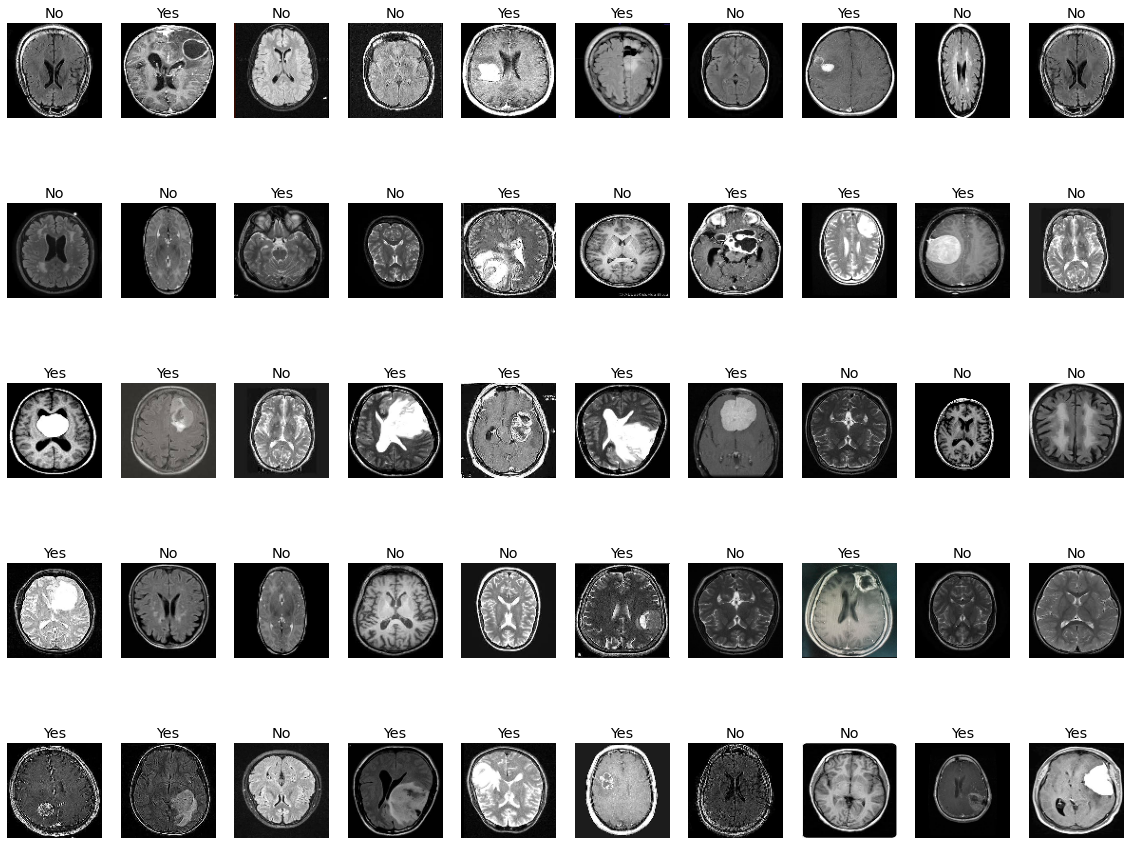

In [9]:
plot_sample_images(X_train, T_train)

Since we did not end up cropping the data and standardizing using the contours, all of the images above have a different head shape but all the images are 100x100x3

# Training Model for Br35H Brain Tumor Detection 2020 Dataset

For this section we will focus on creating a model for the [BR35H](https://www.kaggle.com/ahmedhamada0/brain-tumor-detection) dataset.



In [10]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

def getModel():
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='binary_crossentropy',
      optimizer='adam', metrics=['accuracy'])
    return model


In [11]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                        

Below we create an early stop function that monitors on patience level. We also create a learning_rate_reduction when the model begins to plateau based on val_accuracy.

In [12]:
# earlystop = EarlyStopping(monitor='val_loss')
earlystop = EarlyStopping(patience = 5)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [13]:
# Without weight
history = model.fit(X_train, T_train , epochs = 25,
                    validation_data=(X_test, T_test),
                    callbacks = callbacks
                   )

Epoch 1/25
57/57 [==============================] - 33s 563ms/step - loss: 0.4386 - accuracy: 0.8206 - val_loss: 0.3146 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 2/25
57/57 [==============================] - 32s 562ms/step - loss: 0.1688 - accuracy: 0.9394 - val_loss: 0.2208 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 3/25
57/57 [==============================] - 31s 553ms/step - loss: 0.1477 - accuracy: 0.9483 - val_loss: 0.3989 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 4/25
57/57 [==============================] - 34s 591ms/step - loss: 0.1141 - accuracy: 0.9611 - val_loss: 0.1653 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 5/25
57/57 [==============================] - 31s 542ms/step - loss: 0.0615 - accuracy: 0.9833 - val_loss: 0.1305 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/25
57/57 [==============================] - 35s 611ms/step - loss: 0.0313 - accuracy: 0.9911 - val_loss: 0.0886 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 7/25
57/57 [==============================] - 31s 541ms/st

As observed above, the accuracy begins to plateau--and any further training only loses accuracy. The earlystop functionality keeps us from overfitting the data but is not always used.

In [14]:
def plot_history(history):    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc)
    plt.plot(x, val_acc)
    plt.title('Accuracy vs. No. of epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(x, loss)
    plt.plot(x, val_loss)
    plt.title('Loss vs. No. of epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.show()

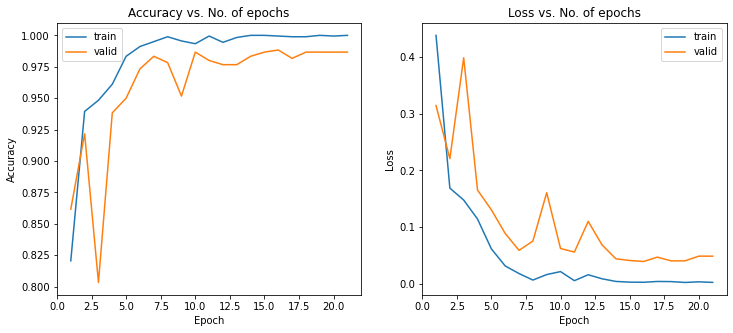

In [15]:
plot_history(history)

In [16]:
def getAccuracyUsingPred(y, y_pred):
    return round((y[y_pred[:,0]==y[:,0]].shape[0] / y.shape[0]) * 100, 2)

# Predicts training, testing, and validation sets and prints accuracies
def predictions(model, X_train, T_train, X_test, T_test, X_validate, T_validate):
    train_pred = model.predict(X_train).round()
    test_pred = model.predict(X_test).round()
    validate_pred = model.predict(X_validate).round()
    
    print(f'Training Accuracy:\t{getAccuracyUsingPred(T_train, train_pred)}%')
    print(f'Testing Accuracy:\t{getAccuracyUsingPred(T_test, test_pred)}%')
    print(f'Validation Accuracy:\t{getAccuracyUsingPred(T_validate, validate_pred)}%')
    
    return train_pred, test_pred, validate_pred

In [17]:
train_pred, test_pred, validate_pred = predictions(model, X_train, T_train, X_test,
                                                   T_test, X_validate, T_validate)

Training Accuracy:	100.0%
Testing Accuracy:	98.67%
Validation Accuracy:	98.17%


After training on the training set, we were able to achieve high accuracy values of ~95-99% on both the testing and validation sets.

However, to further understand why we are unable to get 100% accuracy on these, we explore the confusion matrices below. 

We use sklearn library to generate the confusion matrices.

In [18]:
def getConfusionMatrix(y, y_pred):
    # np.argmax() undoes to_categorical method.
    matrix = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
    disp=cm.ConfusionMatrixDisplay(confusion_matrix = matrix,
                               display_labels=['No', 'Yes'])
    return disp

def graphConfusionMatrix(listOfMatrixDisp, listOfLabels):
    fig, ax = plt.subplots(1, len(listOfMatrixDisp), figsize=(20,5))
    colors = [plt.cm.Blues, plt.cm.BuGn, plt.cm.GnBu]
    
    if len(listOfMatrixDisp) == 1:
        disp = listOfMatrixDisp[0]
        disp.plot(ax=ax, cmap=colors[0])
        disp.ax_.set_title(listOfLabels[0])
    else:
        for i, disp in enumerate(listOfMatrixDisp):
            disp.plot(ax=ax[i], cmap=colors[i % 3])
            disp.ax_.set_title(listOfLabels[i])

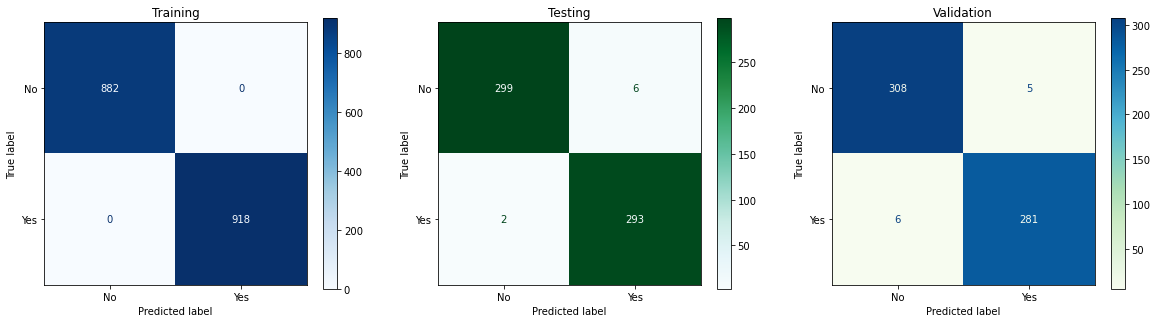

In [19]:
train_cf = getConfusionMatrix(T_train, train_pred)
test_cf = getConfusionMatrix(T_test, test_pred)
validate_cf = getConfusionMatrix(T_validate, validate_pred)

graphConfusionMatrix([train_cf, test_cf, validate_cf], ['Training', 'Testing', 'Validation'])

When looking at these confusion matrices, we can determine how our model is misclassifying the images. Since these models would be used in the health industry, we would prefer the model to have a *lower* false negative rate than a false positive rate. Inititally, our model had a higher false negative rate (which is *not* desired) due to the cropping functionality discussed above. After we removed the cropping functionality, there have been no changes to the difference between false negatives and false positives, but overall the model has a higher accuracy. 

To further explore why we are still misclassifying images, below we will construct a new array of the misclassified images in training, testing, and validation sets and graph the images below.

In [20]:
# Gets indexes of incorrectly classified images in a set
def getIncorrectImages(y, y_pred):
    return np.where(np.argmax(y, axis=1) != np.argmax(y_pred, axis=1))

def getWrongXandY(X_train, T_train, train_pred, X_test, T_test, test_pred, X_validate, T_validate, validate_pred):
    # Combines all incorrectly classified images into a single array
    wrongIndices = getIncorrectImages(T_train, train_pred)
    wrong_X = X_train[wrongIndices]
    wrong_y = T_train[wrongIndices]

    wrongIndices = getIncorrectImages(T_test, test_pred)
    wrong_X = np.vstack((wrong_X, X_test[wrongIndices]))
    wrong_y = np.vstack((wrong_y, T_test[wrongIndices]))

    wrongIndices = getIncorrectImages(T_validate, validate_pred)
    wrong_X = np.vstack((wrong_X, X_validate[wrongIndices]))
    wrong_y = np.vstack((wrong_y, T_validate[wrongIndices]))

    return wrong_X, wrong_y

In [21]:
wrong_X, wrong_y = getWrongXandY(X_train, T_train, train_pred, X_test, T_test, test_pred, X_validate, T_validate, validate_pred)
wrong_X.shape, wrong_y.shape

((19, 100, 100, 3), (19, 2))

### NOTICE: The images below are the MRI scans with the True Label above them that were misclassified by our model.

Images with labels 'Yes' are actually images that **do** have a tumor and images with labels 'No' are images that **do not** contain tumors. All of these images below were misclassified.

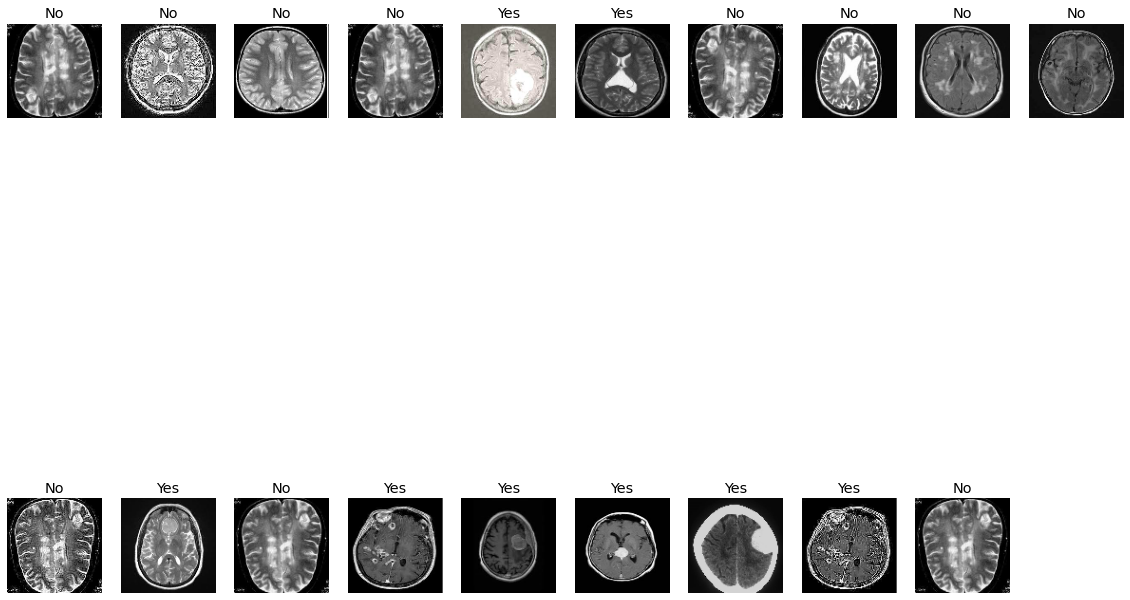

In [22]:
plot_sample_images(wrong_X, wrong_y, n=wrong_X.shape[0])

## Results BR35H

From our CNN model, we were able to achieve ~95-99% accuracy on training, testing and validation sets. 

When we display the incorrectly classified brain tumors, many of the false positive images (labels 'No' above) generally contained brighter/lighter shaded areas. This may suggest that our model is training on color of the MRI scans over the shapes. 

Similarly, most of the false negatives (labels 'Yes' above) contained spherical/circular tumors above but in a darker shade, further suggesting color is being weighted higher in our model for determining if there is a tumor or not. Oddly enough, some of these images do have brighter patches but are still misclassified (could be a indicator of overfitting or fitting to positioning of the tumor brain).

# Training Model for Brain MRI Images for Brain Tumor Detection Dataset

For this section we will focus on creating a model for the [Brain MRI](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) dataset.

### Loading The Data

In [23]:
data_path = "./data/brain_tumor_dataset/"

# Let s indicates 'smaller' file (dataset above)
Xs, ys = get_X_and_y(data_path)

print(f'Number of Yes: {ys[ys==1].shape[0]}\nNumber of No: {ys[ys==0].shape[0]}')
Xs.shape, ys.shape

Number of Yes: 155
Number of No: 98


((253, 100, 100, 3), (253, 1))

### This dataset is imbalanced:

As we can see above, this dataset contains 155 (61%) MRI scans that contain a brain tumor and 98 (39%) MRI scans that do not contain a brain tumor.

Since the dataset is imbalanced, we will resample the data to balance it. Because the dataset only contain 253 samples, however, we will randomly resample the images on the 'No' images to match the number of 'Yes' Images.
In other words, we will be oversampling the 'No' dataset to deal with the imbalance before splitting the data. Note: the random resample process does not allow duplicates when select the samples to resample (The data will never have the same image three times to avoid overfitting). 

Using the oversampling method, the data is more proned to overfitting the data (more on this later).

In [24]:
# Gets random indexes from 'No' dataset

random_no_indexes = np.random.choice(np.where(ys==0)[0], size=57, replace=False)
resampled_no = Xs[random_no_indexes]

Xs = np.vstack((resampled_no, Xs))
ys = np.vstack((np.zeros(57).reshape((-1, 1)), ys))

print(f'Number of Yes: {ys[ys==1].shape[0]}\nNumber of No: {ys[ys==0].shape[0]}')
Xs.shape, ys.shape

Number of Yes: 155
Number of No: 155


((310, 100, 100, 3), (310, 1))

### Splitting the data
After oversampling and balancing the dataset, we now have 310 images, all with a size of 100x100x3. With this, we will once again split the data into 60% training, 20% testing, and 20% validation sets.

In [25]:
Xs_train, Ts_train, Xs_test, Ts_test, Xs_validate, Ts_validate = get_train_test_validation(Xs, ys, randSeed=42)

Xs_train.shape, Ts_train.shape, Xs_test.shape, Ts_test.shape, Xs_validate.shape, Ts_validate.shape

((186, 100, 100, 3),
 (186, 2),
 (62, 100, 100, 3),
 (62, 2),
 (62, 100, 100, 3),
 (62, 2))

### Visualizing this dataset

To get a better view and understanding of this dataset, we will graph the first 50 samples from the training set below. 

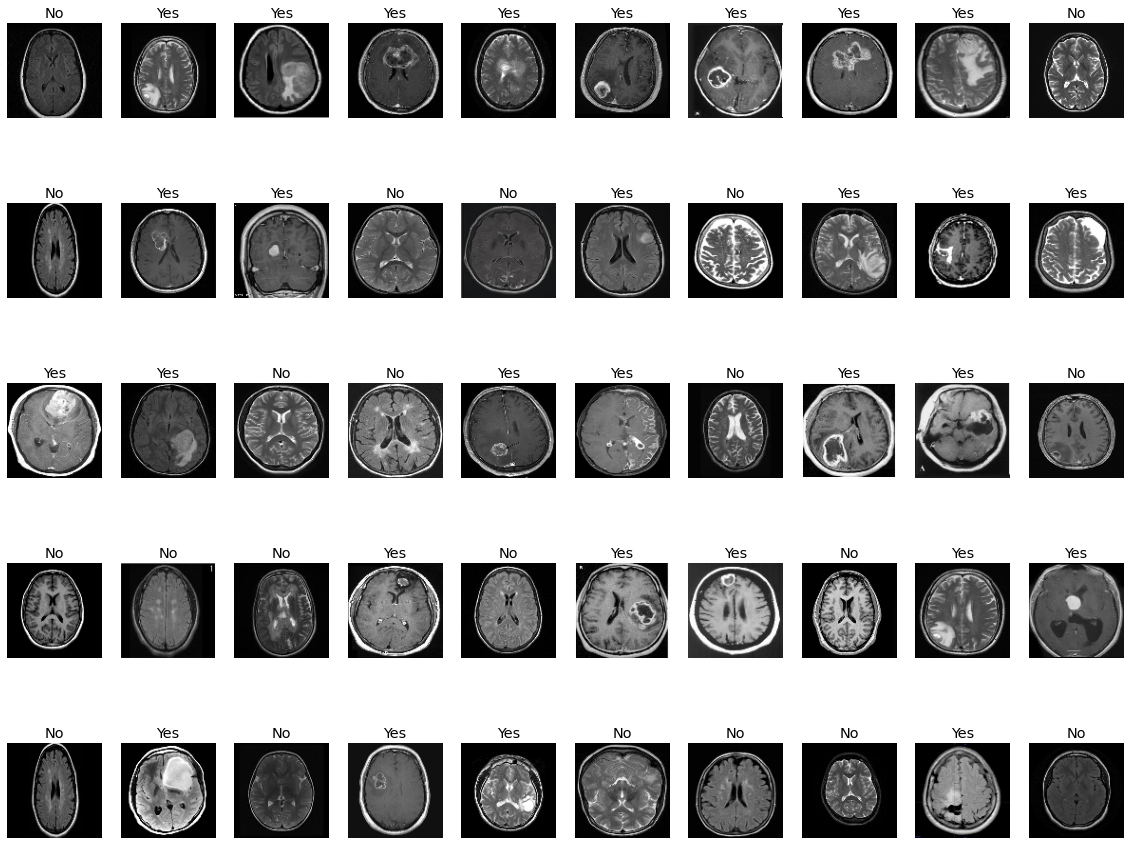

In [26]:
plot_sample_images(Xs_train, Ts_train)

#### Initial Observations

This dataset seems to have more variety of different brain/head shapes. 

Nevertheless, the images closely resemble the other dataset--allowing the same modeling and analysis to be performed below. 

### Modeling the Brain MRI Dataset

Below we create a similar model to the Br35H dataset, but instead train the data on the Brain MRI dataset.

In [27]:
model_s = getModel()
model_s.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                      

In [28]:
# callbacks already initialized above -- These are just reminders

# earlystop = EarlyStopping(monitor='val_loss')
# # earlystop = EarlyStopping(patience = 10)
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
# callbacks = [earlystop,learning_rate_reduction]

In [29]:
history_s = model_s.fit(Xs_train, Ts_train , epochs = 50,
                    validation_data=(Xs_test, Ts_test),
                    callbacks = callbacks
                   )

Epoch 1/50
6/6 [==============================] - 4s 536ms/step - loss: 0.7480 - accuracy: 0.7527 - val_loss: 6.1537 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 3s 570ms/step - loss: 0.2371 - accuracy: 0.9140 - val_loss: 6.2494 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9516
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 3s 577ms/step - loss: 0.1806 - accuracy: 0.9516 - val_loss: 4.1398 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 3s 541ms/step - loss: 0.1042 - accuracy: 0.9785 - val_loss: 3.2933 - val_accuracy: 0.5645 - lr: 5.0000e-04
Epoch 5/50
6/6 [==============================] - 3s 543ms/step - loss: 0.0643 - accuracy: 0.9946 - val_loss: 1.3920 - val_accuracy: 0.7581 - lr: 5.0000e-04
Epoch 6/50
6/6 [==============================] - 3s 534ms/step - loss

Since this was a lightweight dataset, the model trains on the data over more epochs but was much quicker than the other model.

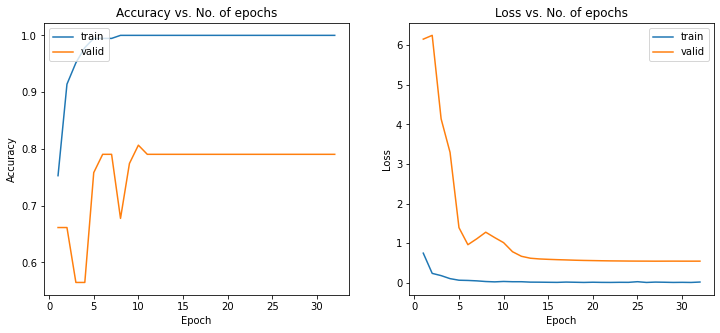

In [30]:
plot_history(history_s)

In [31]:
train_pred_s, test_pred_s, validate_pred_s = predictions(model_s, Xs_train, Ts_train, Xs_test,
                                                         Ts_test, Xs_validate, Ts_validate)

Training Accuracy:	100.0%
Testing Accuracy:	79.03%
Validation Accuracy:	93.55%


Based on several tests, we were able to get 80+% accuracy when generating a model on the training data. 

Despite having an overall lower accuracy than the other dataset, an 80% accuracy is good for a lightweight model. but unfortunately not acceptable considering this is for the medical industry. 

To see why the model is misclassifying these images, we will again look at the confusion matrices and the graphs of the misclassified images.

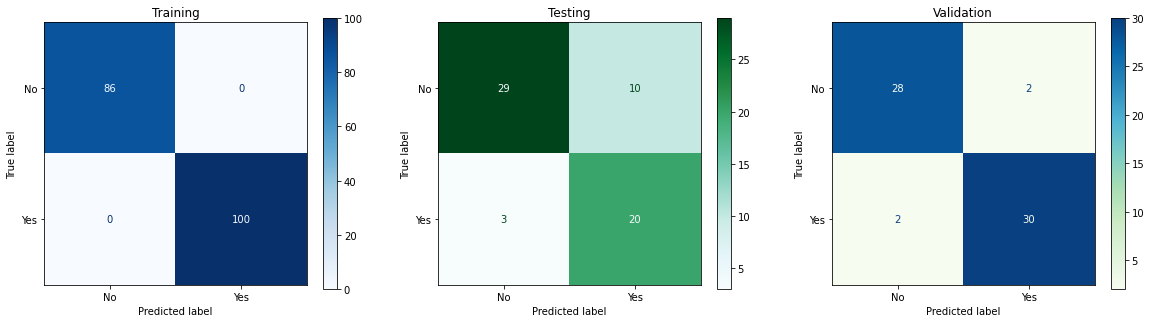

In [32]:
train_cf_s = getConfusionMatrix(Ts_train, train_pred_s)
test_cf_s = getConfusionMatrix(Ts_test, test_pred_s)
validate_cf_s = getConfusionMatrix(Ts_validate, validate_pred_s)

graphConfusionMatrix([train_cf_s, test_cf_s, validate_cf_s], ['Training', 'Testing', 'Validation'])

Similar to the Br35H model, since these models would be used in the health industry, we would prefer the model to have a lower false negative rate than a false positive rate. Just like the other dataset, our model did perform worse and had a higher false negative rate when we used the cropping method above. Likewise, once we removed the cropping the false negative rate had no change compared to the false positive rates but did achieve higher accuracy overall.

To compare whether the same observations can be made on the misclassified images of this dataset and model, below we will construct and graph the array of misclassified images.


In [33]:
wrong_Xs, wrong_ys = getWrongXandY(Xs_train, Ts_train, train_pred_s, Xs_test, Ts_test, test_pred_s, Xs_validate, Ts_validate, validate_pred_s)
wrong_Xs.shape, wrong_ys.shape

((17, 100, 100, 3), (17, 2))

### NOTICE: The images below are the MRI scans with the True Label above them that were misclassified by our model.

Images with labels 'Yes' are actually images that **do** have a tumor and images with labels 'No' are images that **do not** contain tumors. All of these images below were misclassified.

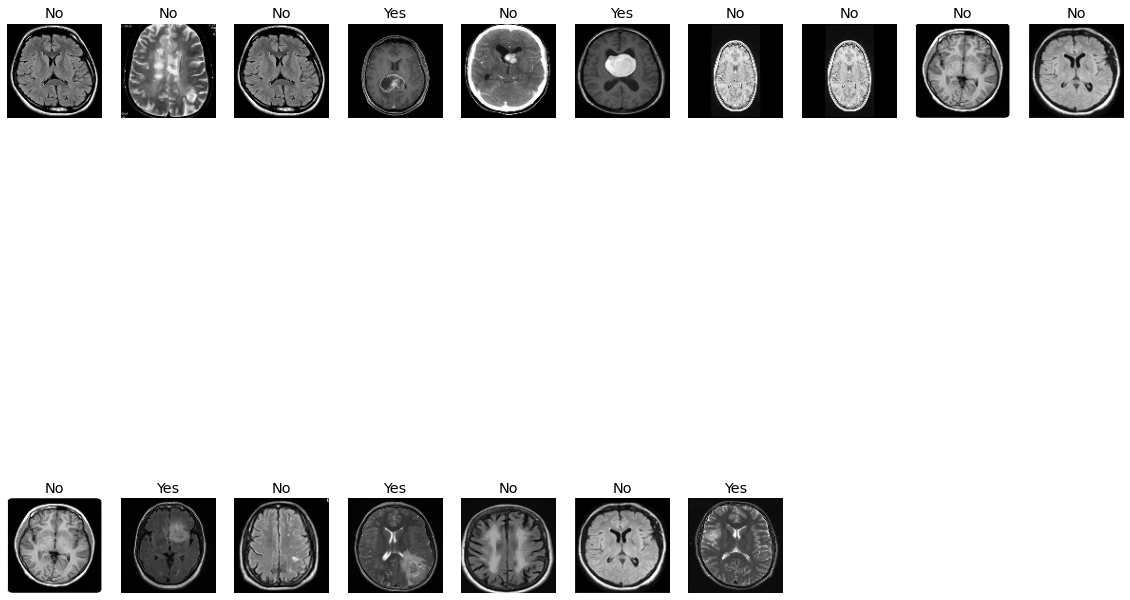

In [34]:
plot_sample_images(wrong_Xs, wrong_ys, n=wrong_Xs.shape[0])

## Results Brain MRI Dataset

Based on this model, there is on average a 75-90% accuracy when predicting images (mainly due to the lack of training data). This model has a inconsistent range of accuracy since we had to resample (oversample) the 'No' dataset (see above).

Strangely enough, some of the iamges above that were false positives (images with the label 'No') did not contain any brighter/lighter areas, but still was classified as having a tumor. Since we oversampled our data above, and took out the cropping function, this may indicate that this model is focusing more on the headshape and 'wrinkles' of the brain, instead of the color and shape of the tumor. 

Likewise, the false negatives (images with the label 'Yes') above often had clear circular/brighter areas of the brain but was still misclassified--reinforcing that this model wasn't using color and shape of the tumor as the main characteristic in determining if a tumor was present.

Note: when we add back the cropping function or decide not resample the data, the accuracies are still lower than the current model. There will occassionally be duplicates in the incorrectly classified images above due to the oversampling of data. This usually occurs when the randomly sampled data was not contained in the training set. 

# Cross Predictions

To ensure that our models above are not overfitting the dataset, we will perform cross predicting on the two datasets and models below. In other words, we will use a model to predict the other dataset.


### Using Br35H model on Brain MRI dataset

In [35]:
BR35H_train_pred, BR35H_test_pred, BR35H_validate_pred = predictions(model, Xs_train, Ts_train, Xs_test,
                                                                     Ts_test, Xs_validate, Ts_validate)

Training Accuracy:	98.92%
Testing Accuracy:	98.39%
Validation Accuracy:	98.39%


To no surprise, the Br35H model does extremely well predicting all of the images in the Brain MRI dataset--achieving 97%+ accuracies. This may indicate that this dataset contains most of the images from the Brain MRI dataset (since the Br35H dataset was constructed afterwards). 

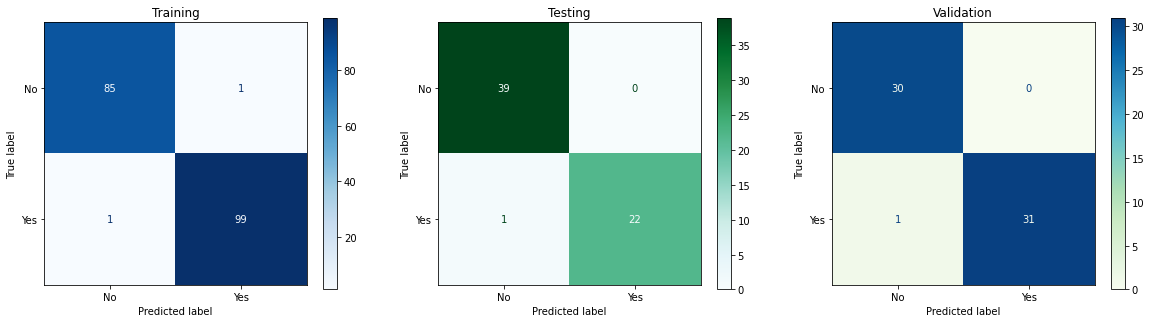

In [36]:
train_BR35H_BMRI = getConfusionMatrix(Ts_train, BR35H_train_pred)
test_BR35H_BMRI = getConfusionMatrix(Ts_test, BR35H_test_pred)
validate_BR35H_BMRI = getConfusionMatrix(Ts_validate, BR35H_validate_pred)

graphConfusionMatrix([train_BR35H_BMRI, test_BR35H_BMRI, validate_BR35H_BMRI], ['Training', 'Testing', 'Validation'])

In [37]:
BR35H_BMRI_X, BR35H_BMRI_y = getWrongXandY(Xs_train, Ts_train, BR35H_train_pred, Xs_test, Ts_test, BR35H_test_pred, Xs_validate, Ts_validate, BR35H_validate_pred)
BR35H_BMRI_X.shape, BR35H_BMRI_y.shape

((4, 100, 100, 3), (4, 2))

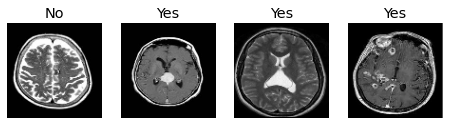

In [38]:
plot_sample_images(BR35H_BMRI_X, BR35H_BMRI_y, n=BR35H_BMRI_X.shape[0])

### Results Br35H Model on Brain MRI Dataset

As we can see above, most of the misclassified images from the Brain MRI datasets appear like outliers compared to the rest of the data (skull shape may be missing, image may be too zoomed in/out, etc.)

These misclassified images could be the main reason the Brain MRI model does not achieve higher accuracy since it may be training on outliers--ultimately messing up the weights.

### Using Brain MRI model on Br35H dataset

In [39]:
BMRI_train_pred, BMRI_test_pred, BMRI_validate_pred = predictions(model_s, X_train, T_train, X_test, T_test, X_validate, T_validate)

Training Accuracy:	85.17%
Testing Accuracy:	86.0%
Validation Accuracy:	85.0%


Using the Brain MRI model on the Br35H dataset, the accuracy is ~75-85%. Despite having a lower accuracy than the Br35H model, this model performs suprisingly well given that it was only trained on 310 images (57 of which were resampled) and predicted these accuracies on a dataset ~10x its size (3000 images). Since we did end up using oversampling to accomdate the imbalance in the dataset, the accuracy may also reflecting a slight overfitting to the original Brain MRI dataset.


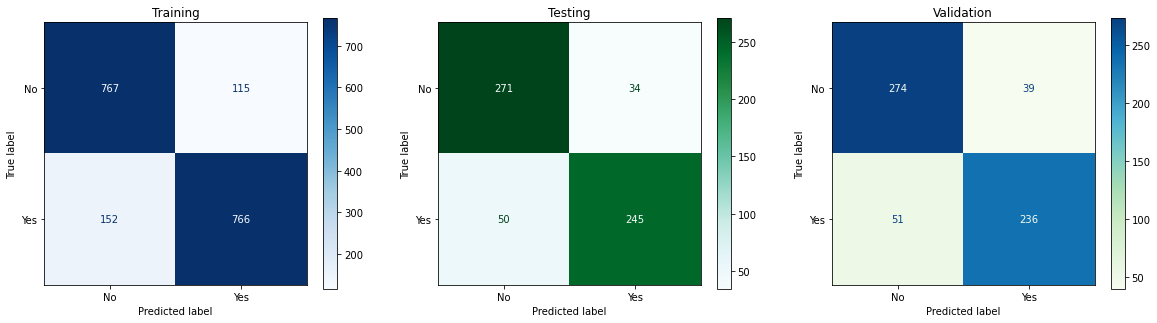

In [40]:
train_BMRI_BR35H = getConfusionMatrix(T_train, BMRI_train_pred)
test_BMRI_BR35H = getConfusionMatrix(T_test, BMRI_test_pred)
validate_BMRI_BR35H = getConfusionMatrix(T_validate, BMRI_validate_pred)

graphConfusionMatrix([train_BMRI_BR35H, test_BMRI_BR35H, validate_BMRI_BR35H], ['Training', 'Testing', 'Validation'])

From the confusion matrices above, there is a significant difference in the number of false negatives vs. the number of false positives when predicting the Br35H dataset. Since this model will be used in the medical industry, this is *NOT* ideal. Below we will look at a couple of the images that are misclassified.

In [41]:
BMRI_BR35H_X, BMRI_BR35H_y = getWrongXandY(X_train, T_train, BMRI_train_pred, X_test, T_test, BMRI_test_pred, X_validate, T_validate, BMRI_validate_pred)
BMRI_BR35H_X.shape, BMRI_BR35H_y.shape

((441, 100, 100, 3), (441, 2))

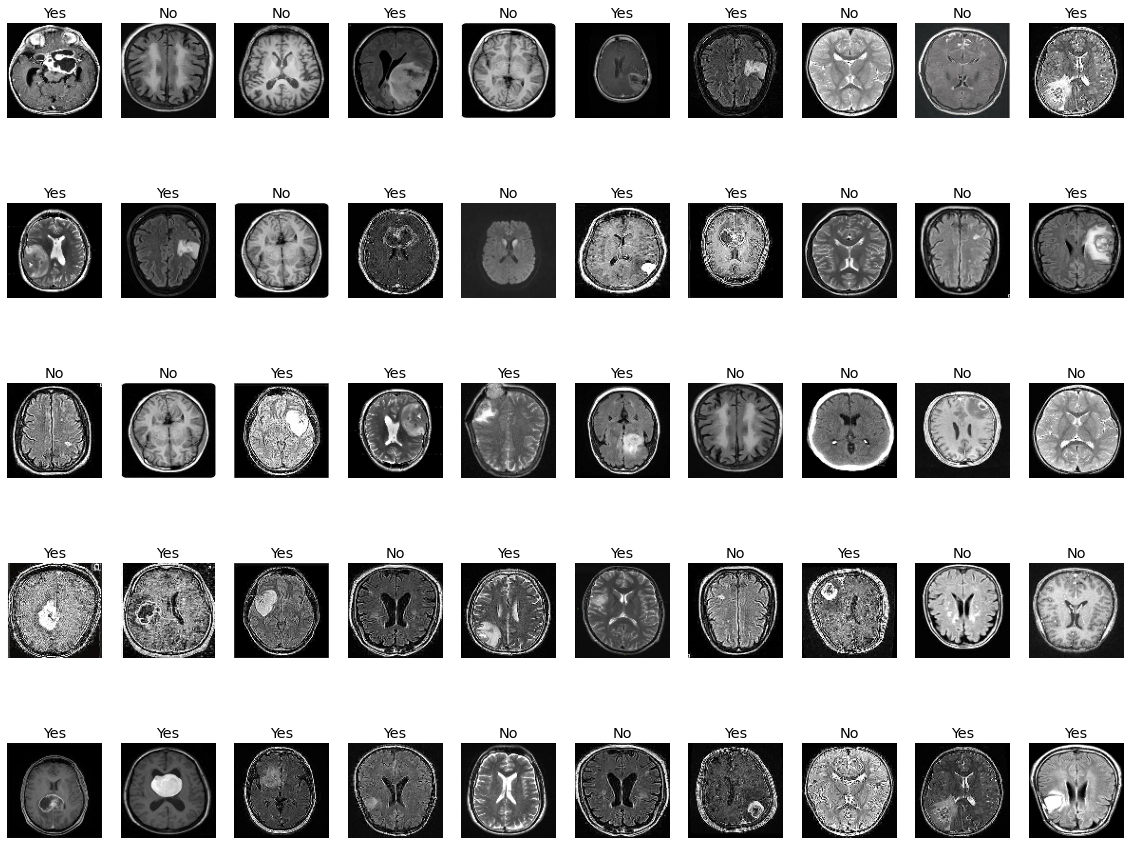

In [42]:
# Only graphing 50 
plot_sample_images(BMRI_BR35H_X, BMRI_BR35H_y, 50 if BMRI_BR35H_X.shape[0] > 50 else BMRI_BR35H_X.shape[0])

### Results Brain MRI Model on Br35H Dataset

The significant images above are the ones with the label 'Yes' (the false negatives). From the set of labels 'Yes', most of the images contain white and circular areas that can be easily classified by viewing the image. 

Despite these images clearly containing a tumor (and still misclassified as not having one), this indicates that the Brain MRI model is not using color or shape of the tumor as the primary characteristic when classifying MRI scans. Other factors, such as head shape, wrinkles, and zoom level may be a contributing factor. 

If we remove the outliers (seen above in Br35H model on Brain MRI dataset) from the Brain MRI dataset, the lightweight model may perform better at predicting unseen data.

# Conclusion

    // Todo

In [44]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Project-Report.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Project-Report.ipynb is 2490
